In [1]:
import operator
import math
import random

import numpy as np

from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from deap import gp

In [2]:
#@title Protected Division to avoid errors
random.seed(64)
def protectedDiv(left, right):
    with np.errstate(divide='ignore',invalid='ignore'):
        x = np.divide(left, right)
        if isinstance(x, np.ndarray):
            x[np.isinf(x)] = 1
            x[np.isnan(x)] = 1
        elif np.isinf(x) or np.isnan(x):
            x = 1
    return x

In [3]:
#@title Use Boston Housing dataset as input
from sklearn.datasets import load_boston
x, y = load_boston(return_X_y=True)
X = np.swapaxes(x,0,1)
inputs = X.shape[0]

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np

        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets includ

In [4]:
#@title Code to Inspect Dataset
import pandas as pd
boston_dataset = load_boston()
boston = pd.DataFrame(boston_dataset.data, columns=boston_dataset.feature_names)
boston['MEDV'] = boston_dataset.target
boston.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [5]:
#@title Create Set of Operators
pset = gp.PrimitiveSet("MAIN", inputs)
pset.addPrimitive(np.add, 2, name="vadd")
pset.addPrimitive(np.subtract, 2, name="vsub")
pset.addPrimitive(np.multiply, 2, name="vmul")
pset.addPrimitive(protectedDiv, 2)
pset.addPrimitive(np.negative, 1, name="vneg")
pset.addPrimitive(np.cos, 1, name="vcos")
pset.addPrimitive(np.sin, 1, name="vsin")
pset.addEphemeralConstant("rand101", lambda: random.randint(-1,1))

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/deap/gp.py:254: RuntimeWarning: Ephemeral rand101 function cannot be pickled because its generating function is a lambda function. Use functools.partial instead.
  warnings.warn("Ephemeral {name} function cannot be "


In [6]:
#@title Setup Fitness Criteria
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

In [7]:
#@title Open the Toolbox
toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=2)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)

In [8]:
#@title Define a Fitness/Evaluation Function
def evalSymbReg(individual):
    # Transform the tree expression in a callable function
    func = toolbox.compile(expr=individual)
    # Evaluate the sum of squared difference between the expression
    diff = math.sqrt(np.sum((func(*X.tolist()) - y)**2)) # unfold list of inputs x using *
    return diff,

In [9]:
#@title Add Genetic Operators to Toolbox
toolbox.register("evaluate", evalSymbReg)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register('mutate', gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

In [10]:
#@title Code to Plot the Expression Tree
import matplotlib.pyplot as plt
import networkx as nx

def plot_expression(individual):
  options = {"node_size": 500, "alpha": 0.8}
  nodes, edges, labels = gp.graph(individual)

  g = nx.Graph()
  g.add_nodes_from(nodes)
  g.add_edges_from(edges)

  pos = nx.spring_layout(g)
  nx.draw_networkx_nodes(g, pos, **options)
  nx.draw_networkx_edges(g, pos, width=1.0, alpha=0.5)
  nx.draw_networkx_labels(g, pos, labels, font_size=9, font_color='k')
  plt.show()

In [11]:

#@title Defining the Evolution Function
def eaSimple(population, toolbox, cxpb, mutpb, ngen, stats=None, halloffame=None):
    logbook = tools.Logbook()
    logbook.header = ['gen', 'nevals'] + (stats.fields if stats else [])

    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in population if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    if halloffame is not None:
        halloffame.update(population)

    record = stats.compile(population) if stats else {}
    logbook.record(gen=0, nevals=len(invalid_ind), **record)
    print(logbook.stream)
    done = False

    # Begin the generational process
    for gen in range(1, ngen + 1):
        if done: return
        # Select the next generation individuals
        offspring = toolbox.select(population, len(population))

        offspring = [toolbox.clone(ind) for ind in offspring]

        # Apply crossover and mutation on the offspring
        for i in range(1, len(offspring), 2):
            if random.random() < cxpb:
                offspring[i - 1], offspring[i] = toolbox.mate(offspring[i - 1],
                                                              offspring[i])
                del offspring[i - 1].fitness.values, offspring[i].fitness.values

        for i in range(len(offspring)):
            if random.random() < mutpb:
                offspring[i], = toolbox.mutate(offspring[i])
                del offspring[i].fitness.values

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)

        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit
            if fit[0] <= 135:
              print("Solved")
              done = True

        # Update the hall of fame with the generated individuals
        if halloffame is not None:
            halloffame.update(offspring)
            plot_expression(halloffame[0])
            print(halloffame[0])
            func = toolbox.compile(expr=halloffame[0])
            rows = x.shape[0]
            random_indices = np.random.choice(rows, size=1, replace=False)
            rd = x[random_indices, :]
            test = func(*rd[0].tolist())
            print(test)

        # Replace the current population by the offspring
        population[:] = offspring

        # Append the current generation statistics to the logbook
        record = stats.compile(population) if stats else {}
        logbook.record(gen=gen, nevals=len(invalid_ind), **record)
        print(logbook.stream)

gen	nevals	avg   	std        	min    	max        
0  	10000 	559364	2.52076e+07	189.713	1.85702e+09


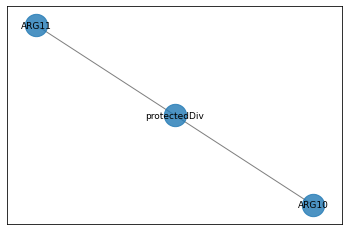

protectedDiv(ARG11, ARG10)
20.671875
1  	5501  	6716.07	173534     	189.713	1.00861e+07


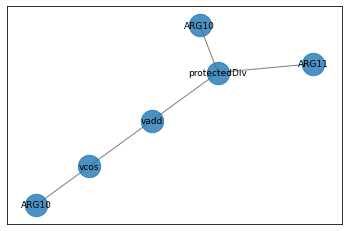

vadd(vcos(ARG10), protectedDiv(ARG11, ARG10))
21.764943049090963
2  	5617  	6951.6 	284901     	188.051	2.58269e+07


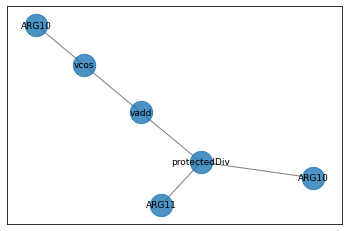

vadd(vcos(ARG10), protectedDiv(ARG11, ARG10))
24.81705249067313
3  	5511  	11357.3	631823     	188.051	5.89109e+07


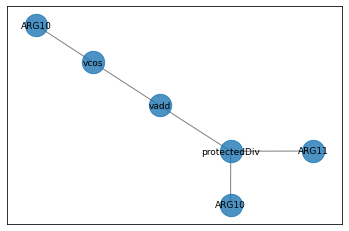

vadd(vcos(ARG10), protectedDiv(ARG11, ARG10))
0.5987713875872429
4  	5387  	12508.6	1.01695e+06	188.051	1.01558e+08


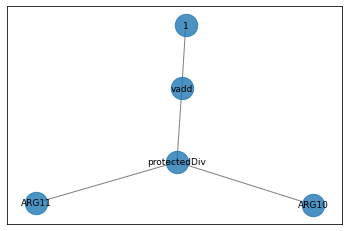

vadd(1, protectedDiv(ARG11, ARG10))
17.740594059405943
5  	5425  	12148.9	662976     	183.479	5.23608e+07


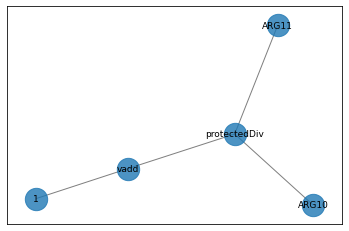

vadd(1, protectedDiv(ARG11, ARG10))
20.063861386138612
6  	5492  	6132.35	287519     	183.479	2.53524e+07


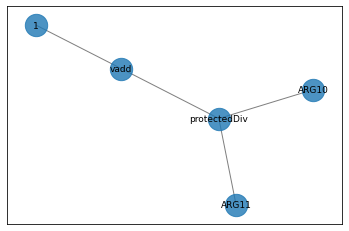

vadd(1, protectedDiv(ARG11, ARG10))
6.987074829931974
7  	5556  	35159.4	2.78946e+06	183.479	2.7311e+08 


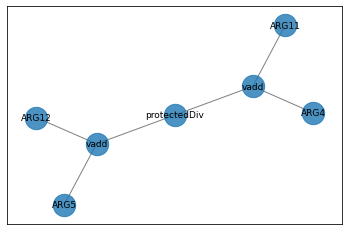

protectedDiv(vadd(ARG4, ARG11), vadd(ARG12, ARG5))
23.336677949709863
8  	5466  	55626.1	4.97066e+06	151.829	4.95822e+08


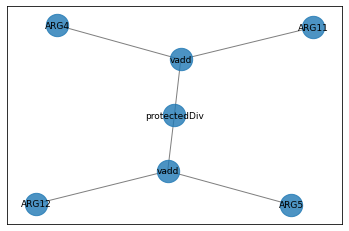

protectedDiv(vadd(ARG4, ARG11), vadd(ARG12, ARG5))
19.61356233343204
9  	5578  	9404.85	558439     	174.878	5.41715e+07


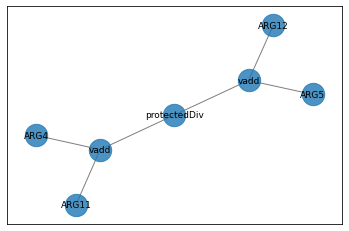

protectedDiv(vadd(ARG4, ARG11), vadd(ARG12, ARG5))
28.2369068287037
10 	5488  	10414.9	677080     	174.878	6.70729e+07


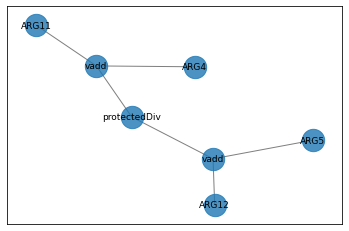

protectedDiv(vadd(ARG4, ARG11), vadd(ARG12, ARG5))
12.740013421396531
11 	5420  	10710.6	641605     	174.878	6.32365e+07


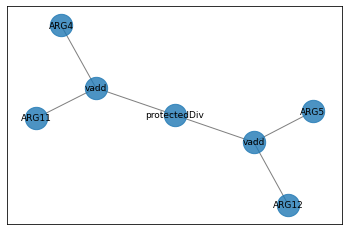

protectedDiv(vadd(ARG4, ARG11), vadd(ARG12, ARG5))
16.886037559780707
12 	5538  	5140.56	84724.7    	163.301	3.44351e+06


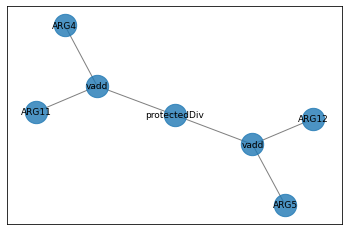

protectedDiv(vadd(ARG4, ARG11), vadd(ARG12, ARG5))
31.0
13 	5673  	5111.98	145749     	163.301	1.11278e+07


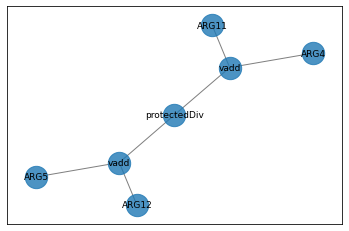

protectedDiv(vadd(ARG4, ARG11), vadd(ARG12, ARG5))
17.31279849274854
14 	5564  	17301.8	1.09178e+06	155.553	1.08209e+08


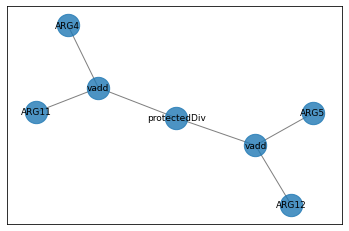

protectedDiv(vadd(ARG4, ARG11), vadd(ARG12, ARG5))
14.651060498751258
15 	5499  	12281.8	698505     	153.355	6.85477e+07


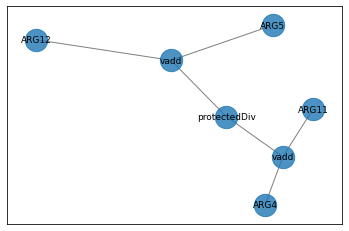

protectedDiv(vadd(ARG4, ARG11), vadd(ARG12, ARG5))
10.947312384023363
16 	5457  	31371.4	1.63694e+06	153.355	1.48728e+08


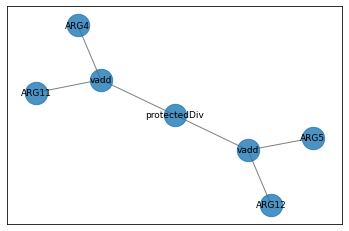

protectedDiv(vadd(ARG4, ARG11), vadd(ARG12, ARG5))
35.069014712438694
17 	5493  	70972.6	3.48278e+06	153.355	2.48576e+08


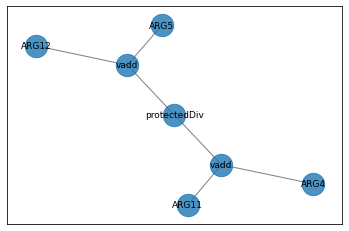

protectedDiv(vadd(ARG4, ARG11), vadd(ARG12, ARG5))
21.11395646606914
18 	5529  	92058.4	6.24557e+06	151.91 	5.64439e+08


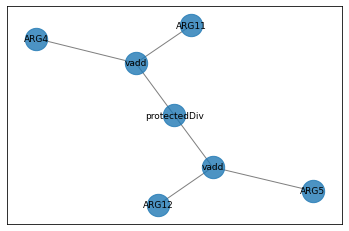

protectedDiv(vadd(ARG4, ARG11), vadd(ARG12, ARG5))
39.36257016840417
19 	5490  	39108.5	2.76272e+06	151.91 	2.6608e+08 


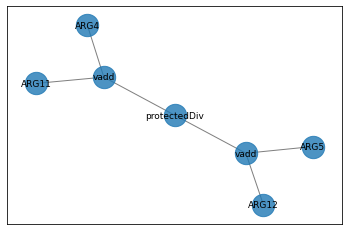

protectedDiv(vadd(ARG4, ARG11), vadd(ARG12, ARG5))
24.205440843085594
20 	5567  	122478 	1.1345e+07 	151.91 	1.13375e+09


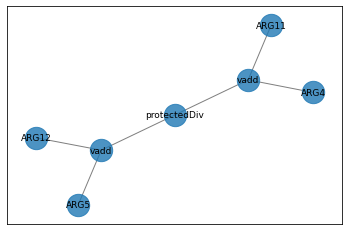

protectedDiv(vadd(ARG4, ARG11), vadd(ARG12, ARG5))
19.471524288107204
21 	5482  	137356 	7.00471e+06	151.91 	4.97779e+08


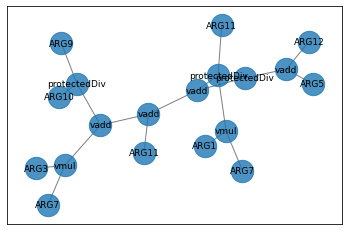

protectedDiv(vadd(protectedDiv(ARG11, vmul(ARG7, ARG1)), vadd(vadd(vmul(ARG7, ARG3), protectedDiv(ARG9, ARG10)), ARG11)), vadd(ARG12, ARG5))
13.083635886970209
22 	5587  	15170.9	790690     	150.377	7.55556e+07


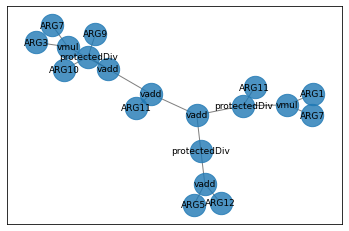

protectedDiv(vadd(protectedDiv(ARG11, vmul(ARG7, ARG1)), vadd(vadd(vmul(ARG7, ARG3), protectedDiv(ARG9, ARG10)), ARG11)), vadd(ARG12, ARG5))
27.431116242438932
23 	5514  	12694.3	577562     	150.377	4.69337e+07


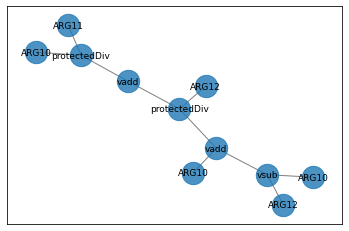

vadd(protectedDiv(ARG11, ARG10), protectedDiv(vadd(vsub(ARG10, ARG12), ARG10), ARG12))
21.00917605538211
24 	5418  	398262 	3.92203e+07	149.493	3.92214e+09


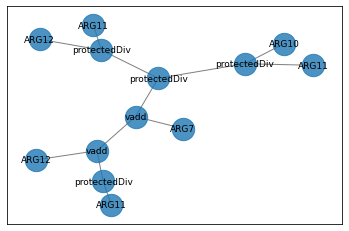

protectedDiv(ARG11, vadd(ARG12, vadd(ARG7, protectedDiv(protectedDiv(ARG11, ARG12), protectedDiv(ARG11, ARG10)))))
0.7885160543654239
25 	5448  	4229.93	128738     	145.932	9.03612e+06


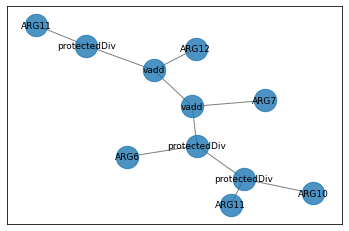

protectedDiv(ARG11, vadd(ARG12, vadd(ARG7, protectedDiv(ARG6, protectedDiv(ARG11, ARG10)))))
21.787892073896714
26 	5647  	23300.9	1.34883e+06	140.925	1.28965e+08


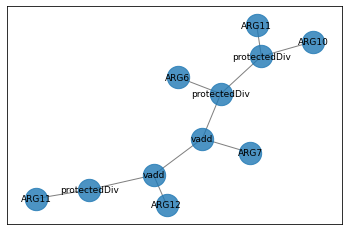

protectedDiv(ARG11, vadd(ARG12, vadd(ARG7, protectedDiv(ARG6, protectedDiv(ARG11, ARG10)))))
11.444330896554236
27 	5392  	4280.62	155871     	142.085	1.35616e+07
Solved


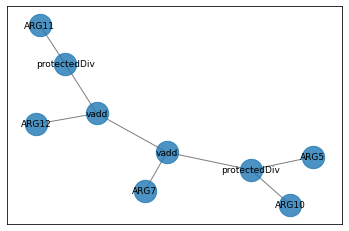

protectedDiv(ARG11, vadd(ARG12, vadd(ARG7, protectedDiv(ARG10, ARG5))))
21.867039001577464
28 	5547  	14302.6	678452     	130.48 	5.57017e+07


In [12]:
#@title Run the Evolution
pop = toolbox.population(n=10000)
hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

eaSimple(pop, toolbox, 0.5, 0.1, 400, stats, halloffame=hof)